## Import the packages

In [27]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from tqdm.notebook import tqdm
from queue import Queue
import psutil
import glob
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt

## Match the airport and weather station
 In this step, we want to match the airport and weather station by calculating the distance through longitude and latitude with the `geodesic` package and selecting the closest weather station so that we can know the weather conditions in every airports.

In [ ]:
airports = pd.read_csv('airport.csv')
weather_stations = pd.read_csv('weather_station.csv')

In [ ]:
airports.head()

In [ ]:
weather_stations.head()

In [ ]:
# Delete the weather station that don't have any data.
values_to_remove = [
    'USW00004742', 'USW00014738', 'USW00014761', 'USW00014851', 'USW00014917', 
    'USW00022525', 'USW00022526', 'USW00023043', 'USW00023195', 'USW00023231', 
    'USW00094071', 'USW00013733', 'USW00093232', 'USC00397666', 'USW00014735', 
    'USW00014925', 'USW00024089', 'USW00025339', 'USW00023167', 'USW00093795', 
    'USW00023167', 'USW00063851', 'USW00003056', 'USW00023230', 'USW00024031', 
    'USW00026445', 'USW00014916'
]
weather_stations = weather_stations[~weather_stations['station'].isin(values_to_remove)]

In [ ]:
# Write a function to merge the data between aiport and weather station.
def air_station(airport_data, station_data):
    results = []
    for _, airport in airport_data.iterrows():
        airport_coords = (airport['latitude_deg'], airport['longitude_deg'])
        min_distance = float('inf')
        closest_station = None

        for _, station in station_data.iterrows():
            station_coords = (station['latitude'], station['longtitude'])
            distance = geodesic(airport_coords, station_coords).kilometers

            if distance < min_distance:
                min_distance = distance
                closest_station = station['name']
                station_id = station['station']

        results.append({
            'airport_name': airport['name'],
            'airport_local_code': airport['local_code'],
            'closest_station': closest_station,
            'station_id': station_id,
            'distance_km': min_distance,
            'state': airport['local_region']
        })

        name = airport['name']
        print(f'{name} is finished.')

    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
closest_data = air_station(airports, weather_stations)

In [ ]:
closest_data.head()

In [ ]:
closest_data.to_csv('closest.csv')

## Next step: deal with the data with all airports :)
In this step, we want to know the weather conditions at both the departure and arrival airports. However, there are 6 time zones in USA. To figure it out, we have to recognize the time zones for each airport.

In [5]:
## Wrtie a function to change the time into datetime form.
def time_form(dataframe, column_date, column_time):
    # Convert column_date to datetime format
    dataframe[column_date] = pd.to_datetime(dataframe[column_date], format='%Y-%m-%d')
    
    # Ensure the time is in 4-digit string format (e.g., 1230 -> 12:30)
    if pd.api.types.is_integer_dtype(dataframe[column_time]):
        dataframe[column_time] = dataframe[column_time].apply(lambda x: f"{int(x):04d}")
    elif pd.api.types.is_float_dtype(dataframe[column_time]):
        dataframe[column_time] = dataframe[column_time].apply(lambda x: f"{int(x):04d}" if pd.notnull(x) else x)
    
    # Replace any "2400" times with "0000" and increment the date by one day
    dataframe[column_time] = dataframe[column_time].replace('2400', '0000')
    dataframe[column_date] = dataframe.apply(
        lambda row: row[column_date] + pd.Timedelta(days=1) if row[column_time] == '0000' else row[column_date],
        axis=1
    )
    
    # Combine date and time into datetime format
    dataframe[column_time] = pd.to_datetime(
        dataframe[column_date].dt.strftime('%Y-%m-%d') + ' ' + dataframe[column_time].str[:2] + ':' + dataframe[column_time].str[2:],
        format='%Y-%m-%d %H:%M'
    )
    return dataframe[column_time]

In [6]:
## Define a mapping of U.S. states to their corresponding time zones.
# Note: Some states may have more than one time zone, but we are simplifying the definition by using a primary time zone for each state.
state_timezone_map = {
    'AL': 'CST', 'AK': 'AKST', 'AZ': 'MST','AR': 'CST','CA': 'PST','CO': 'MST',
    'CT': 'EST','DE': 'EST','FL': 'EST','GA': 'EST','HI': 'HST','ID': 'MST', 'IL': 'CST',
    'IN': 'EST', 'IA': 'CST','KS': 'CST','KY': 'EST','LA': 'CST','ME': 'EST','MD': 'EST','MA': 'EST',
    'MI': 'EST','MN': 'CST','MS': 'CST','MO': 'CST','MT': 'MST','NE': 'CST','NV': 'PST','NH': 'EST',
    'NJ': 'EST','NM': 'MST','NY': 'EST','NC': 'EST','ND': 'CST','OH': 'EST','OK': 'CST','OR': 'PST',
    'PA': 'EST','RI': 'EST','SC': 'EST','SD': 'CST','TN': 'CST','TX': 'CST','UT': 'MST','VT': 'EST',
    'VA': 'EST','WA': 'PST','WV': 'EST','WI': 'CST','WY': 'MST', 'PR':'AST', 'VI':'AST'
}

# Define a mapping of time zones to their differences in hours from Hawaii-Aleutian Standard Time (HST). This will facilitate the calculation of time differences for different time zones.
timezone_mapping = {
    'HST': 0,   # Hawaii-Aleutian Standard Time
    'AKST': 1,  # Alaska Standard Time
    'PST': 2,   # Pacific Standard Time
    'MST': 3,   # Mountain Standard Time
    'CST': 4,   # Central Standard Time
    'EST': 5,    # Eastern Standard Time
    'AST': 6    #Atlantic Standard Time
}

def get_timezone(dataframe, state_column):
    timezones = dataframe[state_column].map(state_timezone_map)
    return timezones.map(timezone_mapping)

In [7]:
# Write a function to know the 'CRSDepTime' in the destination airport.
def time_match(dataframe, column_dep_time_zone, column_arr_time_zone, column_dep_time):
    dataframe['Arr_Dep_Diff'] = dataframe[column_arr_time_zone] - dataframe[column_dep_time_zone]
    return dataframe[column_dep_time] + pd.to_timedelta(dataframe['Arr_Dep_Diff'], unit='h')

In [8]:
print(os.getcwd())

C:\Users\NO DICE


In [9]:
flight_folder_base = "PycharmProjects/pythonProject/2_flight_merge"

In [10]:
for year in range(2018, 2024):
    flight_file = os.path.join(flight_folder_base, f'{year}.csv')
    flight_data = pd.read_csv(flight_file)
    tt_rows = (flight_data['OriginState'] == 'TT') & (flight_data['DestState'] == 'TT')
    flight_data = flight_data[~tt_rows]
    
    flight_data['CRSDepTime'] = time_form(flight_data, 'FlightDate','CRSDepTime')
    flight_data['CRSArrTime'] = time_form(flight_data, 'FlightDate','CRSArrTime')
    flight_data['DepTime'] = time_form(flight_data, 'FlightDate','DepTime')
    flight_data['ArrTime'] = time_form(flight_data, 'FlightDate','ArrTime')

    flight_data['OriginTimeZone'] = get_timezone(flight_data, 'OriginState')
    flight_data['DestTimeZone'] = get_timezone(flight_data, 'DestState')

    flight_data['CRSDepTime_Dest'] = time_match(flight_data, 'OriginTimeZone', 'DestTimeZone', 'CRSDepTime')
    
    flight_data.to_csv(flight_file, index=False)

C:\Users\NO DICE\AppData\Local\Temp\ipykernel_55140\4004587037.py:3: DtypeWarning: Columns (11,13,39) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv(flight_file)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_55140\4004587037.py:3: DtypeWarning: Columns (11,13,39) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv(flight_file)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_55140\4004587037.py:3: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv(flight_file)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_55140\4004587037.py:3: DtypeWarning: Columns (11,13,39) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv(flight_file)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_55140\4004587037.py:3: DtypeWarning: Columns (11,13,39) have mixed types. Specify dtype o

## Merge the airport and weather data :(
In this step, we will combine the airport and weather data.  
To merge the data effeciently and quickly, we use `concurrent.futures` and `multiprocessing` in `.py` file. You can see the code in `stat628_module3.py`.

## Deal with the data
In this step, we will deal with the data.  
Below shows how we deal with the data.
1. For `Arrival_HourlyWindGustSpeed`, `Departure_HourlyWindGustSpeed`, `Arrival_HourlyPresentWeatherType`, `Departure_HourlyPresentWeatherType`, `Departure_HourlyPressureTendency`, `Departure_HourlyPressureChange` ,`Arrival_HourlyPressureChange`, and `Arrival_HourlyPressureTendency` columns, we delete them as the missing rate is greater than 69%. 
2. For `Arrival_HourlyWindDirection`, `Departure_HourlyWindDirection`, `Arrival_HourlyRelativeHumidity`, `Departure_HourlyRelativeHumidity`, `Arrival_HourlyDewPointTemperature`, `Departure_HourlyDewPointTemperature`, `Arrival_HourlyDryBulbTemperature`, `Departure_HourlyDryBulbTemperature`, `Arrival_HourlyWindSpped`, `Depature_HourlyWindSpeed`, `Arrival_HourlyWetBulbTemperature`,and `Departure_HourlyWebBulbTemperature`columns, we delete the missing samples.
3. For `Arrival_HourlySkyConditions`, `Departure_HourlySkyConditions`, `Arrival_HourlyStationPressure`, and `Departure_HourlyStationPressure` columns, we use means to impute.
4. For `Arrival_HourlyVisibility` and `Departure_HourlyVisibility` columns, we use median to impute.
5. For `Arrival_HourlySkyConditions` and `Depature_HourlySkyConditions` columns, we use one-hot encoding.
6. For `DepTime`, `CRSArrTime`, `ArrTime`, `CRSDepTime`, and `CRSDepTime_Dest` columns, we use Unix timestamp.
7. For `Arrival_HourlyWindDirection` and `Departure_HourlyWindDirection` columns, we also change the 'VRB' to '999.0'.
8. For `Arrival_HourlyPrecipitation` and `Departure_HourlyPrecipitation` columns, we also change the missing value and 'T' to '0'.
9. To easily build the model, we also extract the time features, which are ***Year***, ***when is the flight departure/arrive (morning, afternoon, and evening)***. 
10. We convert ***the departure and arrvial airports*** into numeric encodings.
11. We convert ***the airport company*** into dummy variables.
12. We calculate the differences between ***the scheduled arrival time*** and ***the actual arrival time*** by using the Unix timestamp.

In [3]:
## Showing the missing rate of each data.
aw_folder = "PycharmProjects/pythonProject/Air_weather"
for year in range(2018, 2024):
    aw_file = os.path.join(aw_folder, f'{year}_airport_weather.csv')
    df = pd.read_csv(aw_file,low_memory=False)
    missing_values = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
    print(f'For {year} year:')
    print(missing_values)

For 2018 year:
Departure_HourlyWindGustSpeed          0.885761
Arrival_HourlyWindGustSpeed            0.885696
Arrival_HourlyPresentWeatherType       0.830303
Departure_HourlyPresentWeatherType     0.829568
Departure_HourlyPressureTendency       0.705420
Departure_HourlyPressureChange         0.705420
Arrival_HourlyPressureChange           0.702341
Arrival_HourlyPressureTendency         0.702341
Departure_HourlyPrecipitation          0.234159
Arrival_HourlyPrecipitation            0.232615
Arrival_HourlyWindDirection            0.159783
Departure_HourlyWindDirection          0.159539
Departure_HourlySkyConditions          0.140778
Arrival_HourlySkyConditions            0.137766
Departure_HourlyVisibility             0.134818
Arrival_HourlyVisibility               0.130919
Departure_HourlySeaLevelPressure       0.126910
Arrival_HourlySeaLevelPressure         0.125422
Departure_HourlyWetBulbTemperature     0.022555
Departure_HourlyStationPressure        0.021807
Arrival_HourlyWetBulbTemp

For 2022 year:
Departure_HourlyWindGustSpeed          0.873022
Arrival_HourlyWindGustSpeed            0.872619
Arrival_HourlyPresentWeatherType       0.849232
Departure_HourlyPresentWeatherType     0.848078
Departure_HourlyPressureTendency       0.708198
Departure_HourlyPressureChange         0.708198
Arrival_HourlyPressureChange           0.707309
Arrival_HourlyPressureTendency         0.707309
Departure_HourlyPrecipitation          0.232718
Arrival_HourlyPrecipitation            0.232389
Arrival_HourlyWindDirection            0.163727
Departure_HourlyWindDirection          0.161932
Departure_HourlySkyConditions          0.145687
Arrival_HourlySkyConditions            0.143725
Departure_HourlyVisibility             0.132720
Arrival_HourlyVisibility               0.130350
Arrival_HourlySeaLevelPressure         0.128007
Departure_HourlySeaLevelPressure       0.127998
ArrTime                                0.028650
DepTime                                0.027759
Arrival_HourlyWetBulbTemp

In [4]:
## Dealing with missing values
aw_folder = "PycharmProjects/pythonProject/Air_weather"
for year in range(2018, 2024):
    aw_file = os.path.join(aw_folder, f'{year}_airport_weather.csv')
    df = pd.read_csv(aw_file,low_memory=False)
    
    columns_to_drop = [
        'Arrival_HourlyWindGustSpeed', 'Departure_HourlyWindGustSpeed', 
        'Arrival_HourlyPresentWeatherType', 'Departure_HourlyPresentWeatherType',
        'Departure_HourlyPressureTendency', 'Departure_HourlyPressureChange', 
        'Arrival_HourlyPressureChange', 'Arrival_HourlyPressureTendency',
        'Arrival_SOURCE', 'Departure_SOURCE', 
        'Departure_REPORT_TYPE', 'Arrival_REPORT_TYPE'
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    
    columns_to_check = [
        'Arrival_HourlyRelativeHumidity', 'Arrival_HourlyDewPointTemperature', 
        'Arrival_HourlyDryBulbTemperature', 'Arrival_HourlyWindSpeed', 
        'Departure_HourlyWetBulbTemperature', 'Departure_HourlyRelativeHumidity', 
        'Departure_HourlyDewPointTemperature', 'Departure_HourlyDryBulbTemperature', 
        'Departure_HourlyWindSpeed', 'Arrival_HourlyWetBulbTemperature'
    ]
    df.dropna(subset=columns_to_check, inplace=True)
    
    df['Departure_SkyConditions_List'] = df['Departure_HourlySkyConditions'].str.findall(r'(CLR|FEW|SCT|BKN|OVC|VV|10)')
    df['Arrival_SkyConditions_List'] = df['Arrival_HourlySkyConditions'].str.findall(r'(CLR|FEW|SCT|BKN|OVC|VV|10)')
    df_one_hot_1 = df['Departure_SkyConditions_List'].str.join('|').str.get_dummies().add_prefix('Dep_')
    df_one_hot_2 = df['Arrival_SkyConditions_List'].str.join('|').str.get_dummies().add_prefix('Arr_')
    df = pd.concat([df, df_one_hot_1, df_one_hot_2], axis=1)
    
    columns_fill_median = ['HourlyVisibility', 'Departure_HourlyVisibility', 'Arrival_HourlyVisibility']
    for col in columns_fill_median:
        if col in df.columns:
            df[col] = df[col].replace(r'[^\d.]+', '', regex=True).replace('', np.nan).astype(float)
            df[col].fillna(df[col].median(), inplace=True)
    
    columns_fill_mean = ['Departure_HourlySeaLevelPressure', 'Arrival_HourlySeaLevelPressure', 'Departure_HourlyStationPressure', 'Arrival_HourlyStationPressure']
    for col in columns_fill_mean:
        if col in df.columns:
            df[col].fillna(df[col].mean(), inplace=True)
    
    col_names_precipitation = ['Departure_HourlyPrecipitation', 'Arrival_HourlyPrecipitation']
    for col in col_names_precipitation:
        if col in df.columns:
            df[col] = df[col].replace('T', 0).fillna(0).astype(float)
    
    col_names_wd = ['Departure_HourlyWindDirection', 'Arrival_HourlyWindDirection']
    for col in col_names_wd:
        if col in df.columns:
            df.dropna(subset=[col], inplace=True)
            df[col] = df[col].replace('VRB', 999.0).astype(float)
    
    col_names_ws = ['Departure_HourlyWindSpeed', 'Arrival_HourlyWindSpeed']
    for col in col_names_ws:
        if col in df.columns:
            df[col] = df[col].replace(r'[^\d.]+', '', regex=True).replace('', np.nan)
            df[col] = df[col].astype(float)
            df.dropna(subset=col_names_ws, inplace=True)
    
    time_columns = ['DepTime', 'CRSArrTime', 'ArrTime', 'CRSDepTime', 'CRSDepTime_Dest']
    for col in time_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f"{col}_num"] = (df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    output_file = os.path.join(aw_folder, f'{year}_air_weather_clean.csv')
    df.to_csv(output_file, index=False)
    print(f"Finished dealing with all the data: {output_file}")

print("Finished dealing with all the files.")


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2018_air_weather_clean.csv


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2019_air_weather_clean.csv


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2020_air_weather_clean.csv


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2021_air_weather_clean.csv


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2022_air_weather_clean.csv


C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\NO DICE\AppData\Local\Temp\ipykernel_50940\4013056915.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Finished dealing with all the data: PycharmProjects/pythonProject/Air_weather\2023_air_weather_clean.csv
Finished dealing with all the files.


In [5]:
file_paths = glob.glob('PycharmProjects/pythonProject/Air_weather/*_air_weather_clean.csv')

data_frames = []

for file in file_paths:
    df = pd.read_csv(file)
    
    year = re.search(r'(\d{4})', file).group(0)
    
    df['Year'] = int(year)
    
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

print(combined_data.head())

   DayOfWeek Origin Dest              DepTime           CRSArrTime  \
0          4    BDL  RDU  2018-11-15 06:00:00  2018-11-15 07:50:00   
1          5    BDL  RDU  2018-11-16 06:31:00  2018-11-16 07:50:00   
2          2    BDL  RDU  2018-11-20 05:58:00  2018-11-20 07:50:00   
3          6    BDL  RDU  2018-11-24 05:58:00  2018-11-24 07:50:00   
4          1    BDL  RDU  2018-11-26 05:56:00  2018-11-26 07:50:00   

               ArrTime           CRSDepTime      CRSDepTime_Dest  Cancelled  \
0  2018-11-15 08:00:00  2018-11-15 06:00:00  2018-11-15 06:00:00          0   
1  2018-11-16 08:59:00  2018-11-16 06:00:00  2018-11-16 06:00:00          0   
2  2018-11-20 07:50:00  2018-11-20 06:00:00  2018-11-20 06:00:00          0   
3  2018-11-24 07:50:00  2018-11-24 06:00:00  2018-11-24 06:00:00          0   
4  2018-11-26 07:53:00  2018-11-26 06:00:00  2018-11-26 06:00:00          0   

  Marketing_Airline_Network  ...  Arr_FEW  Arr_OVC  Arr_SCT  Arr_VV  \
0                        DL  ... 

In [7]:
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

combined_data['CRSArrTime'] = pd.to_datetime(combined_data['CRSArrTime'])
combined_data['CRSDepTime'] = pd.to_datetime(combined_data['CRSDepTime'])

combined_data['ArrTimeOfDay'] = combined_data['CRSArrTime'].dt.hour.apply(categorize_time_of_day)
combined_data['DepTimeOfDay'] = combined_data['CRSDepTime'].dt.hour.apply(categorize_time_of_day)

encoder = OneHotEncoder(sparse_output=False)
encoded_columns = encoder.fit_transform(combined_data[['ArrTimeOfDay', 'DepTimeOfDay']])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['ArrTimeOfDay', 'DepTimeOfDay']))

combined_data = pd.concat([combined_data, encoded_df], axis=1)

combined_data = combined_data.drop(['ArrTimeOfDay', 'DepTimeOfDay'], axis=1)

print(combined_data.head())


   DayOfWeek Origin Dest              DepTime          CRSArrTime  \
0          4    BDL  RDU  2018-11-15 06:00:00 2018-11-15 07:50:00   
1          5    BDL  RDU  2018-11-16 06:31:00 2018-11-16 07:50:00   
2          2    BDL  RDU  2018-11-20 05:58:00 2018-11-20 07:50:00   
3          6    BDL  RDU  2018-11-24 05:58:00 2018-11-24 07:50:00   
4          1    BDL  RDU  2018-11-26 05:56:00 2018-11-26 07:50:00   

               ArrTime          CRSDepTime      CRSDepTime_Dest  Cancelled  \
0  2018-11-15 08:00:00 2018-11-15 06:00:00  2018-11-15 06:00:00          0   
1  2018-11-16 08:59:00 2018-11-16 06:00:00  2018-11-16 06:00:00          0   
2  2018-11-20 07:50:00 2018-11-20 06:00:00  2018-11-20 06:00:00          0   
3  2018-11-24 07:50:00 2018-11-24 06:00:00  2018-11-24 06:00:00          0   
4  2018-11-26 07:53:00 2018-11-26 06:00:00  2018-11-26 06:00:00          0   

  Marketing_Airline_Network  ...  CRSDepTime_Dest_num  Year  \
0                        DL  ...           1542261600

In [8]:
columns_to_drop = ['Arrival_SkyConditions_List','Departure_SkyConditions_List','CRSDepTime_Dest','Departure_HourlySkyConditions','Arrival_HourlySkyConditions']
combined_data = combined_data.drop(columns=columns_to_drop)

In [9]:
label_encoder_origin = LabelEncoder()
label_encoder_dest = LabelEncoder()

combined_data['Origin_Label'] = label_encoder_origin.fit_transform(combined_data['Origin'])
combined_data['Dest_Label'] = label_encoder_dest.fit_transform(combined_data['Dest'])

one_hot_airline = pd.get_dummies(combined_data['Marketing_Airline_Network'], prefix='Airline')

combined_data = pd.concat([combined_data, one_hot_airline], axis=1)
combined_data = combined_data.drop(columns=['Marketing_Airline_Network'])

In [10]:
combined_data['delay_time'] = (combined_data['CRSArrTime_num'] - combined_data['ArrTime_num'])/60

In [11]:
combined_data.to_csv('combined_data.csv', index=False, chunksize=100000)

In [12]:
combined_data.head()

,DayOfWeek,Origin,Dest,DepTime,CRSArrTime,ArrTime,CRSDepTime,Cancelled,Departure_HourlyDewPointTemperature,Departure_HourlyDryBulbTemperature,...,Airline_AS,Airline_B6,Airline_DL,Airline_F9,Airline_G4,Airline_HA,Airline_NK,Airline_UA,Airline_WN,delay_time
0,4,BDL,RDU,2018-11-15 06:00:00,2018-11-15 07:50:00,2018-11-15 08:00:00,2018-11-15 06:00:00,0,-11.1,-5.6,...,False,False,True,False,False,False,False,False,False,-10.0
1,5,BDL,RDU,2018-11-16 06:31:00,2018-11-16 07:50:00,2018-11-16 08:59:00,2018-11-16 06:00:00,0,0.0,0.6,...,False,False,True,False,False,False,False,False,False,-69.0
2,2,BDL,RDU,2018-11-20 05:58:00,2018-11-20 07:50:00,2018-11-20 07:50:00,2018-11-20 06:00:00,0,1.1,1.7,...,False,False,True,False,False,False,False,False,False,0.0
3,6,BDL,RDU,2018-11-24 05:58:00,2018-11-24 07:50:00,2018-11-24 07:50:00,2018-11-24 06:00:00,0,-13.3,-6.1,...,False,False,True,False,False,False,False,False,False,0.0
4,1,BDL,RDU,2018-11-26 05:56:00,2018-11-26 07:50:00,2018-11-26 07:53:00,2018-11-26 06:00:00,0,2.2,2.2,...,False,False,True,False,False,False,False,False,False,-3.0


## Building the model (Shiny Version)
In this step, we build the Decision Tree and Random Forest for prediction delay and cancelation.  
We finally choose Random Forest as our final model.  
These models are for Shiny, if you want to see the complete model, see `model.ipynb`

 #### Delay


In [2]:
combined_data = pd.read_csv("C:/Users/NO DICE/PycharmProjects/pythonProject/combined_data.csv")

In [3]:
columns_to_drop = ['Origin','Dest','CRSDepTime','CRSArrTime','ArrTime','DepTime','DepTime_num','CRSArrTime_num','ArrTime_num','CRSDepTime_num','CRSDepTime_Dest_num','Departure_HourlyStationPressure','Arrival_HourlyStationPressure']
combined = combined_data.drop(columns=columns_to_drop)

In [4]:
delay_data = combined[combined['Cancelled'] == 0]

In [5]:
delay_data=delay_data.dropna()
delay_data = delay_data.drop(columns='Cancelled')

In [6]:
X = delay_data[['ArrTimeOfDay_night', 'Dest_Label', 'Departure_HourlySeaLevelPressure', 
                'Arrival_HourlySeaLevelPressure', 'Origin_Label', 
                'Departure_HourlyWetBulbTemperature', 'Arrival_HourlyWetBulbTemperature', 
                'Departure_HourlyDryBulbTemperature', 'Arrival_HourlyDryBulbTemperature', 'Year']]
y = delay_data['delay_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
tree_model = DecisionTreeRegressor(random_state=42,max_depth=20,min_samples_leaf = 20,min_samples_split=50)

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 27435.372532582038
R² Score: 0.012891170951138564


In [8]:
selector_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=20, max_depth = 30, min_samples_split = 100, n_jobs = -1,verbose = 2)
selector_model.fit(X_train, y_train)

y_pred = selector_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.3s


Mean Squared Error: 25918.807333691504
R² Score: 0.06745630929125923


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.9s finished


In [24]:
joblib.dump(selector_model, 'delay_model.pkl')

['delay_model.pkl']

In [9]:
feature_importances = selector_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

In [10]:
importance_df

,Feature,Importance
0,ArrTimeOfDay_night,0.162841
2,Departure_HourlySeaLevelPressure,0.126273
5,Departure_HourlyWetBulbTemperature,0.117127
1,Dest_Label,0.109626
3,Arrival_HourlySeaLevelPressure,0.108676
6,Arrival_HourlyWetBulbTemperature,0.103036
4,Origin_Label,0.092487
7,Departure_HourlyDryBulbTemperature,0.082114
8,Arrival_HourlyDryBulbTemperature,0.067505
9,Year,0.030315


#### Cancel

In [11]:
combined_1 = combined_data.drop(columns=['delay_time'])

In [14]:
X = combined_1[['ArrTimeOfDay_night', 'Dest_Label', 'Departure_HourlySeaLevelPressure', 
                'Arrival_HourlySeaLevelPressure', 'Origin_Label', 
                'Departure_HourlyWetBulbTemperature', 'Arrival_HourlyWetBulbTemperature', 
                'Departure_HourlyDryBulbTemperature', 'Arrival_HourlyDryBulbTemperature', 'Year']]
y = combined_1['Cancelled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42,max_depth=20,min_samples_leaf = 20,min_samples_split=50,class_weight = 'balanced')
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)
print("Decision Tree Model Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Model Accuracy: 0.8332193285552091
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91   1395822
           1       0.07      0.62      0.12     26633

    accuracy                           0.83   1422455
   macro avg       0.53      0.73      0.51   1422455
weighted avg       0.97      0.83      0.89   1422455



In [17]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=20, max_depth = 30, min_samples_split = 100, n_jobs = -1,verbose = 2,class_weight = 'balanced')
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    5.5s finished


Random Forest Model Accuracy: 0.9446000049210695
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97   1395822
           1       0.17      0.52      0.26     26633

    accuracy                           0.94   1422455
   macro avg       0.58      0.74      0.62   1422455
weighted avg       0.98      0.94      0.96   1422455



In [18]:
cancel_probabilities = rf_classifier.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.1s finished


In [19]:
cancel_probabilities

array([0.13367069, 0.08821981, 0.12442246, ..., 0.38692322, 0.29892993,
       0.03917242])

In [20]:
feature_importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

In [21]:
importance_df

,Feature,Importance
7,Departure_HourlyDryBulbTemperature,0.141571
8,Arrival_HourlyDryBulbTemperature,0.125581
6,Arrival_HourlyWetBulbTemperature,0.119089
5,Departure_HourlyWetBulbTemperature,0.118751
2,Departure_HourlySeaLevelPressure,0.117264
3,Arrival_HourlySeaLevelPressure,0.113672
9,Year,0.091276
4,Origin_Label,0.083229
1,Dest_Label,0.081187
0,ArrTimeOfDay_night,0.008379


In [23]:
combined_data['ArrTimeOfDay_night']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
7112266    0.0
7112267    0.0
7112268    0.0
7112269    0.0
7112270    1.0
Name: ArrTimeOfDay_night, Length: 7112271, dtype: float64

In [25]:
joblib.dump(rf_classifier, 'cancel_model.pkl')

['cancel_model.pkl']

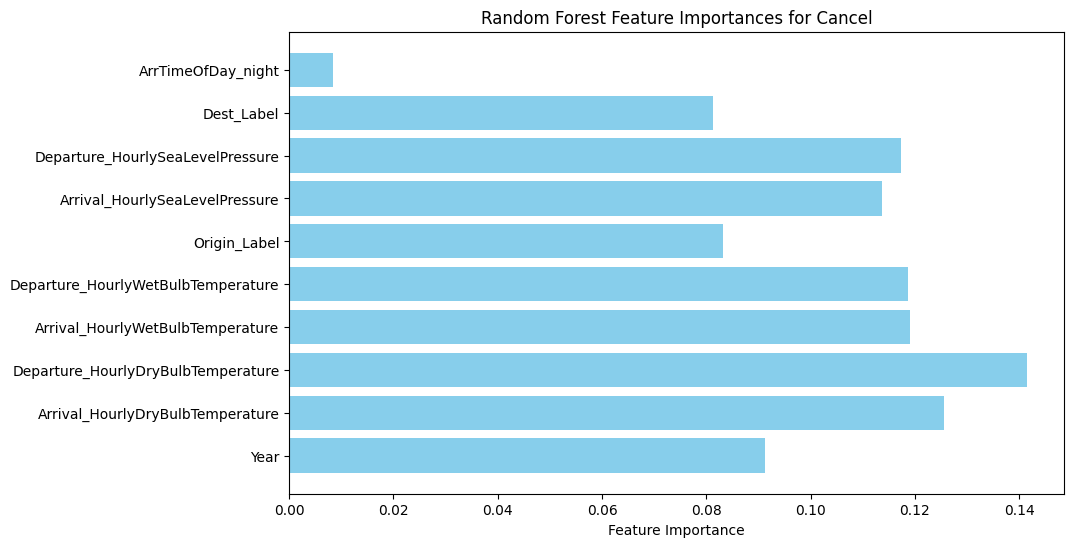

In [30]:
importances = rf_classifier.feature_importances_
features = X_test.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances for Cancel')
plt.gca().invert_yaxis()
plt.show()

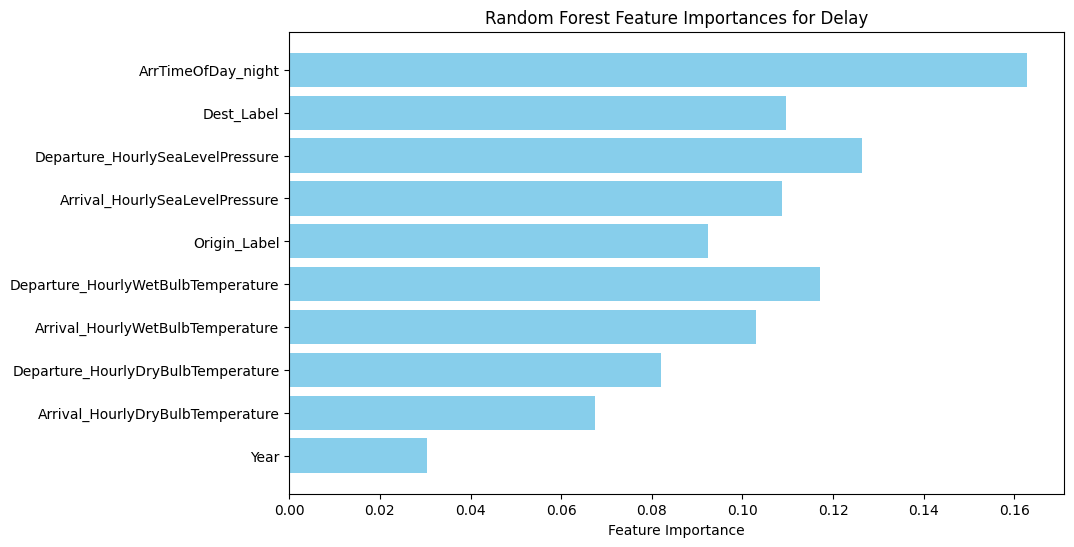

In [31]:
importances = selector_model.feature_importances_
features = X_test.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances for Delay')
plt.gca().invert_yaxis()
plt.show()